# Uncertainty-Aware Road Obstacle Identification
In this notebook, we propose an implementation of Road Obstacle Identification architecture, with the addition of a certain threshold of confidence to uncertainty, thanks to the Conformal Prediction quantification, and a creative approach to the compuation of the so called "Boundary Aware Binary Cross Entropy". These are the main implemented topics:
- **Multilabel One-Hot Encoding and Classes**
- **DeepLabV3+ ResNet50 with sigmoid head**
- **Boundary Aware BCE and Boundary Identification**
- **Unknown Objectness Score and Conformal Prediction**

## 1. Imports

In [1]:
from PIL import Image
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import random
import torchvision.transforms as T
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.optim as optim
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve
import utils  # utils functions defined separately in utils.py

## 2. Globals

Set to False if the dataset folders are still in their original format and need to be reorganized

In [ ]:
IS_FIXED_CITYSCAPES = True
IS_FIXED_LOSTANDFOUND = True

Set the relative path for the dataset

In [ ]:
RELATIVE_PATH = '../../'

In [ ]:
# Macro class index mapping
MACRO_CLASSES = {
    "road": 0,
    "flat": 1,
    "human": 2,
    "vehicle": 3,
    "construction": 4,
    "background": 5,
    "pole": 6,
    "object": 7,  # auxiliary objectness channel
}

# Map from original label ID to (macro class, is_object)
CLASS_MAPPING = {
    7: ("road", False), # road
    8: ("flat", False), # sidewalk
    11: ("construction", False), # building
    12: ("construction", False), # wall
    13: ("construction", False), # fence
    17: ("pole", True),  # pole
    19: ("pole", True),  # traffic sign
    20: ("pole", True),  # traffic light
    21: ("background", False), # vegetation
    22: ("flat", False), # terrain
    23: ("background", False), # sky
    24: ("human", True), # person
    25: ("human", True), # rider
    26: ("vehicle", True), # car
    27: ("vehicle", True), # truck
    28: ("vehicle", True), # bus
    31: ("vehicle", True), # train
    32: ("vehicle", True), # motorcycle
    33: ("vehicle", True), # bicycle
}

CLASS_NAMES_8 = ["road", "flat", "human", "vehicle", "construction", "background", "pole", "object"]

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RESIZED_HEIGHT = 512
RESIZED_WIDTH = 1024

TRANSFORM = T.Compose([
    T.Resize((RESIZED_HEIGHT, RESIZED_WIDTH)),  # Resize to half the original size
    T.ToTensor(),  # converts in [0, 1], shape [3, H, W]
    T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
])

In [3]:
def set_seed(seed=123):
    random.seed(seed)                      # Python
    np.random.seed(seed)                   # NumPy
    torch.manual_seed(seed)                # PyTorch CPU
    torch.cuda.manual_seed(seed)           # PyTorch GPU

set_seed(123)  # Call this at the top of your script

## 3. Data

### Datasets Classes Definition

In [ ]:
class CityscapesTrainEvalDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=TRANSFORM):
        self.transform = transform 
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)

        # Collect all image paths
        self.img_paths = list(self.img_dir.rglob("*.png"))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]

        # Derive corresponding mask path by adding '_m' before the extension
        mask_name = img_path.stem + "_m.png"
        mask_path = self.mask_dir / mask_name

        if not mask_path.exists():
            print(f"Warning: No mask found for image: {img_path.name}")

        # Load and preprocess image
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        else:
            img = T.Compose([
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])(img)

        # Load and resize mask with nearest neighbor interpolation
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale (single channel)
        resized_mask = mask.resize((RESIZED_WIDTH, RESIZED_HEIGHT), resample=Image.NEAREST)

        # Convert resized mask to numpy array and tensor
        mask_np = np.array(resized_mask, dtype=np.uint8)
        mask_tensor = torch.as_tensor(mask_np, dtype=torch.uint8)

        # Convert mask to one-hot encoding
        mask_onehot = utils.convert_label_to_multilabel_one_hot(mask_tensor, "cityscapes")

        return img, mask_onehot, mask_np
    
class CityscapesTestDataset(Dataset):
    def __init__(self, img_dir, transform=TRANSFORM):
        self.img_paths = sorted(Path(img_dir).rglob("*.png"))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        # Resize image to match the expected input size
        if self.transform:
            img = self.transform(img)
        else:
            img = T.Compose([
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])(img)

        return img, str(img_path.name)  # Return the filename for later use

class LostAndFoundTrainEvalDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=TRANSFORM):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.img_paths = sorted(self.img_dir.rglob("*.png"))[:1000] # Limit to 1000 images
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        mask_name = img_path.stem + "_m.png"
        mask_path = self.mask_dir / mask_name

        if not mask_path.exists():
            print(f"Warning: No mask found for image: {img_path.name}")

        # Load image
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        else:
            img = T.Compose([
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])(img)

        # Load and resize mask with nearest neighbor interpolation
        mask = Image.open(mask_path).convert("L")  # grayscale
        resized_mask = mask.resize((RESIZED_WIDTH, RESIZED_HEIGHT), resample=Image.NEAREST)

        # Convert resized mask to numpy array and tensor
        mask_np = np.array(resized_mask, dtype=np.uint8)
        mask_tensor = torch.as_tensor(mask_np, dtype=torch.uint8)
        
        # Convert mask to one-hot encoding
        mask_onehot = utils.convert_label_to_multilabel_one_hot(mask_tensor, "lostandfound")

        return img, mask_onehot, mask_np  # [3,H,W], [8,H,W], [H,W]

### Fixing the Datasets

Here are the functions to fix the structure of the two datasets, downloaded from the official CityScapes and LostAndFound websites

In [ ]:
# Fix the CityScapes dataset
if not IS_FIXED_CITYSCAPES:
    print("Fixing cityscapes dataset...")
    utils.fix_cityscapes(RELATIVE_PATH + 'cityscapes', RELATIVE_PATH + 'cityscapes_f')

In [ ]:
# Fix the LostAndFound dataset
if not IS_FIXED_LOSTANDFOUND:
    print("Fixing lostandfound dataset...")
    utils.fix_lostandfound(RELATIVE_PATH + 'lostandfound', RELATIVE_PATH + 'lostandfound_f')

### Loading the Datasets

In [ ]:
train_set_c = CityscapesTrainEvalDataset(RELATIVE_PATH + 'cityscapes_f/img/train', RELATIVE_PATH + 'cityscapes_f/mask/train')
benchmark_set_c = CityscapesTrainEvalDataset(RELATIVE_PATH + 'cityscapes_f/img/val', RELATIVE_PATH + 'cityscapes_f/mask/val')

# Split the training set into training, validation and calibration sets
train_size_c = len(train_set_c)
cal_and_val_size_c = int(0.2 * train_size_c)
cal_size_c = int(0.5 * cal_and_val_size_c)  # 10% of the original training set size
train_set_c, calib_and_val_set_c = random_split(train_set_c, [train_size_c - cal_and_val_size_c, cal_and_val_size_c])
cal_set_c, val_set_c = random_split(calib_and_val_set_c, [cal_size_c, cal_and_val_size_c - cal_size_c])

batch_size_c = 5
train_loader = DataLoader(train_set_c, batch_size=batch_size_c, shuffle=True, drop_last=True) # drop_last=True to ensure all batches have the same size
val_loader = DataLoader(val_set_c, batch_size=batch_size_c, shuffle=False, drop_last=True)
cal_loader = DataLoader(cal_set_c, batch_size=batch_size_c, shuffle=False, drop_last=True)
benchmark_loader = DataLoader(benchmark_set_c, batch_size=batch_size_c, shuffle=False, drop_last=True)

for imgs_c, masks_c, original_mask_c in val_loader:
    print("Batch of images shape:", imgs_c.shape)  # Should be [B, 3, H, W]
    print("Batch of masks shape:", masks_c.shape)  # Should be [B, 8, H, W]
    print("Original mask shape:", original_mask_c.shape)  # Should be [B, H, W]
    break

Batch of images shape: torch.Size([5, 3, 512, 1024])
Batch of masks shape: torch.Size([5, 8, 512, 1024])
Original mask shape: torch.Size([5, 512, 1024])


In [ ]:
dataset_lf = LostAndFoundTrainEvalDataset(RELATIVE_PATH + 'lostandfound_f/img/train', RELATIVE_PATH + 'lostandfound_f/mask/train')

# Split the LostAndFound dataset into training and validation sets
train_size_lf = int(0.8 * len(dataset_lf))
val_size_lf = len(dataset_lf) - train_size_lf

train_set_lf, val_set_lf = random_split(dataset_lf, [train_size_lf, val_size_lf])

batch_size_lf = 5
train_loader_lf = DataLoader(train_set_lf, batch_size=batch_size_lf, shuffle=True, drop_last=True)
val_loader_lf = DataLoader(val_set_lf, batch_size=batch_size_lf, shuffle=False, drop_last=False)

for imgs_lf, masks_lf, original_mask_lf in train_loader_lf:
    print("Batch of images shape:", imgs_lf.shape)  # Should be [B, 3, H, W]
    print("Batch of masks shape:", masks_lf.shape)  # Should be [B, 8, H, W]
    print("Original mask shape:", original_mask_lf.shape)  # Should be [B, H, W]
    break  # Just to check the first batch

Batch of images shape: torch.Size([5, 3, 512, 1024])
Batch of masks shape: torch.Size([5, 8, 512, 1024])
Original mask shape: torch.Size([5, 512, 1024])


### Some Visualization

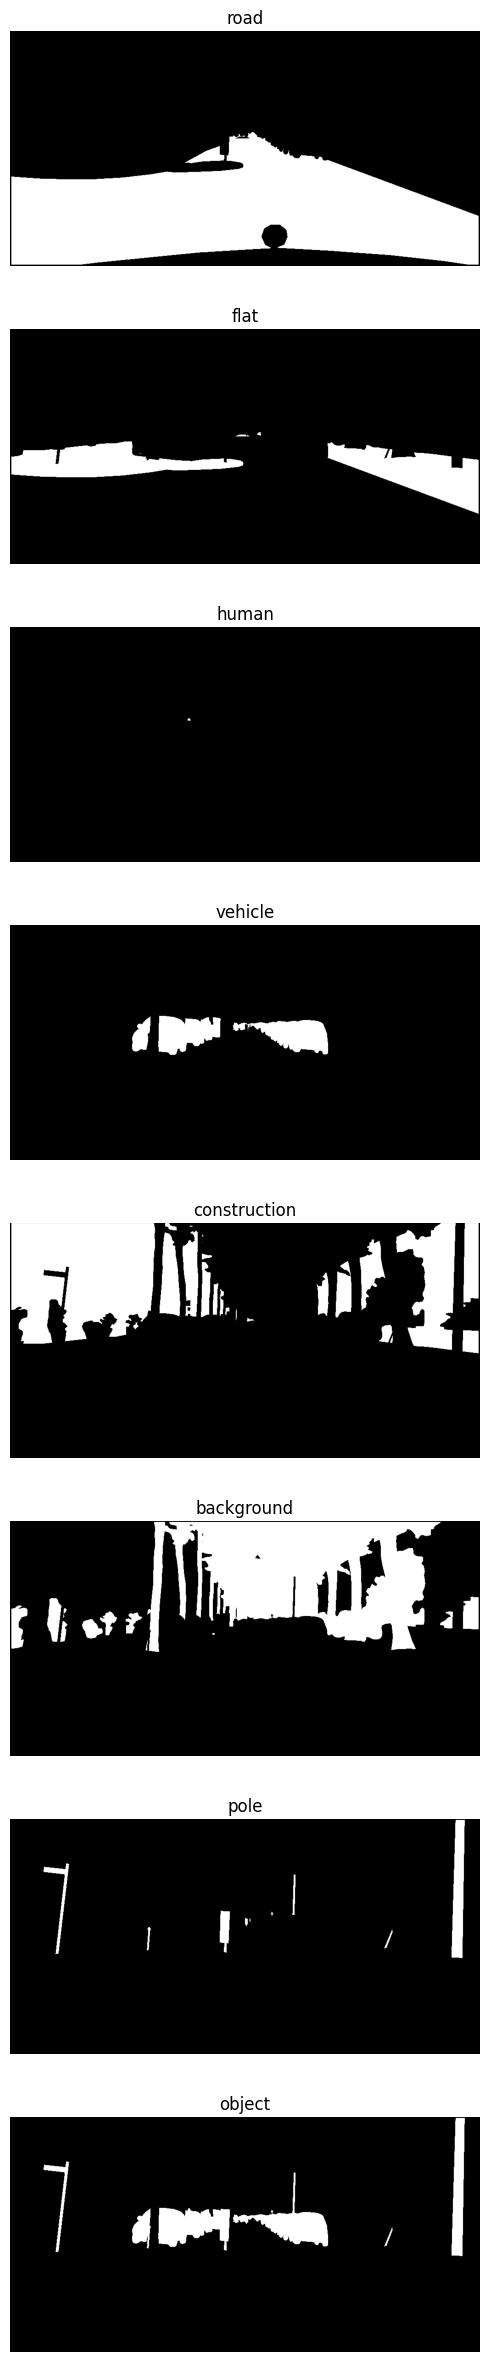

In [ ]:
utils.visualize_one_hot(masks_c[1], class_names=CLASS_NAMES_8)

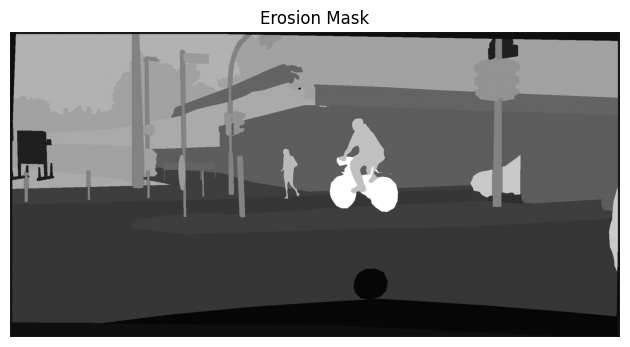

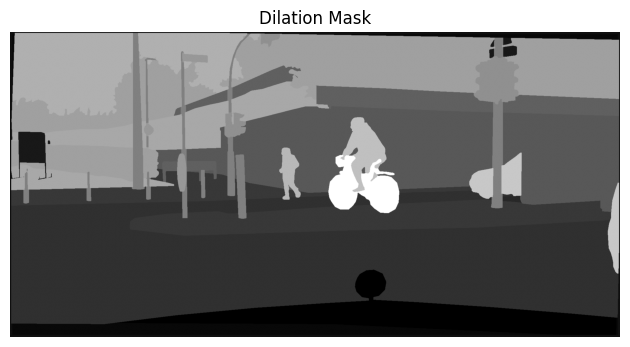

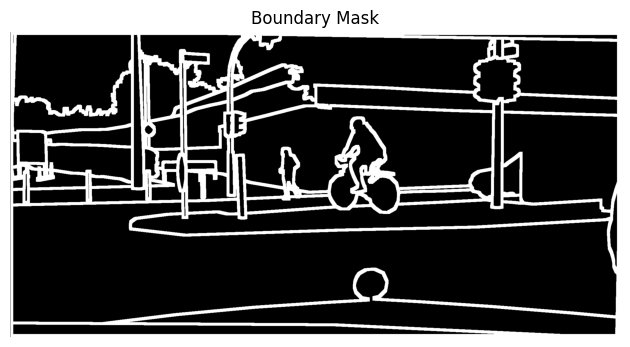

In [ ]:
utils.visualize_erosion_mask(np.array(Image.open(RELATIVE_PATH + 'cityscapes_f/mask/train/train1_m.png')), iterations=5)
utils.visualize_dilation_mask(np.array(Image.open(RELATIVE_PATH + 'cityscapes_f/mask/train/train1_m.png')), iterations=5)
utils.visualize_boundary_mask(np.array(Image.open(RELATIVE_PATH + 'cityscapes_f/mask/train/train1_m.png')), iterations=5)

## 4. Network

### Network Class and Losses Definition

**Network Class**

In [ ]:
class MultiLabelDeepLabV3(nn.Module):
    def __init__(self, n_classes=8):
        super().__init__()
        # Load pretrained model
        self.model = deeplabv3_resnet50(pretrained=True)

        # Replace classifier to output 8 channels with sigmoid
        self.model.classifier[-1] = nn.Conv2d(
            in_channels=256,
            out_channels=n_classes,
            kernel_size=1
        )
    
    def forward(self, x):
        x = self.model(x)['out']
        return torch.sigmoid(x)  # Apply sigmoid for multilabel outputs

**Loss Class for Cityscapes Dataset**

In [ ]:
class BoundaryAwareBCELoss(nn.Module):
    def __init__(self, lambda_weight=3.0):
        super().__init__()
        self.lambda_weight = lambda_weight

    def forward(self, pred, target, boundary_mask):
        eps = 1e-7  # Small value to avoid log(0)

        # Standard BCE loss
        bce = -(target * torch.log(pred + eps) + (1 - target) * torch.log(1 - pred + eps))
        normal_term = bce.mean()

        # Ensure boundary_mask is a float tensor
        boundary_mask = boundary_mask.float()
        
        # Set the boundary_mask to have the same number of dimensions as pred
        if boundary_mask.dim() == 3:
            boundary_mask = boundary_mask.unsqueeze(1)

        # Expansion to (B, C, H, W) to do the product    
        boundary_mask = boundary_mask.expand(-1, pred.shape[1], -1, -1)

        # boundary aware BCE loss
        boundary_bce = bce * boundary_mask
        num_boundary_pixels = boundary_mask.sum(dim=(1, 2, 3)).clamp(min=1.0)  # Boundary pixels of each image
        boundary_loss = boundary_bce.sum(dim=(1, 2, 3)) / num_boundary_pixels
        boundary_term = boundary_loss.mean()

        return normal_term + self.lambda_weight * boundary_term

**Loss Class for LostAndFound Dataset**

In [ ]:
class BoundaryAwareBCELossFineTuning(nn.Module):
    def __init__(self, lambda_weight=3.0):
        super().__init__()
        self.lambda_weight = lambda_weight

    def forward(self, pred, target, boundary_mask):
        eps = 1e-7  # Small value to avoid log(0)

        # Standard BCE loss
        bce = -(target * torch.log(pred + eps) + (1 - target) * torch.log(1 - pred + eps))

        # -------------------------------
        # Create a mask: pixels with at least one GT class > 0
        # Shape: (B, H, W)
        valid_pixel_mask = (target.sum(dim=1) > 0).float()

        # Expand to match shape (B, C, H, W)
        valid_pixel_mask = valid_pixel_mask.unsqueeze(1).expand_as(target)

        # Apply the pixel mask
        bce = bce * valid_pixel_mask
        num_valid_pixels = valid_pixel_mask.sum(dim=(1, 2, 3)).clamp(min=1.0)
        normal_loss = bce.sum(dim=(1, 2, 3)) / num_valid_pixels
        normal_term = normal_loss.mean()
        # -------------------------------

        # Expand boundary mask if needed
        if boundary_mask.dim() == 3:
            boundary_mask = boundary_mask.unsqueeze(1)
        boundary_mask = boundary_mask.expand_as(target)
            
        boundary_bce = bce * boundary_mask
        num_boundary_pixels = (boundary_mask * valid_pixel_mask).sum(dim=(1, 2, 3)).clamp(min=1.0)
        boundary_loss = boundary_bce.sum(dim=(1, 2, 3)) / num_boundary_pixels
        boundary_term = boundary_loss.mean()

        return normal_term + self.lambda_weight * boundary_term

### Model Setup

In [ ]:
model = MultiLabelDeepLabV3(n_classes=8).to(DEVICE)

criterion = BoundaryAwareBCELoss(lambda_weight=3.0)

# Parameters
initial_lr = 0.01
momentum = 0.9
weight_decay = 0.0001
power = 0.9
num_epochs = 1
boundary_iterations = 5

optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)

# Calculate max iterations for poly schedule
max_iter = num_epochs * len(train_loader)
current_iter = 0

# Early stopping parameters
best_val_loss = float('inf')
patience = 3
counter = 0
early_stop = False

/home/miketango2002/universita/magistrale/anno_I/semestre_II/cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/miketango2002/universita/magistrale/anno_I/semestre_II/cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 5. Train

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # ---- TRAINING STEP ----
    for imgs, masks, original_mask in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        preds = model(imgs)
        # Get boundary masks
        boundary_masks = utils.get_boundary_mask_batch(original_mask, iterations=boundary_iterations).detach().to(DEVICE)
        loss = criterion(preds, masks, boundary_masks)
        loss.backward()
        optimizer.step()

        # Poly LR update
        current_iter += 1
        lr = initial_lr * (1 - current_iter / max_iter) ** power
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    
    # ---- VALIDATION STEP ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks, original_mask in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = model(imgs)
            boundary_masks = utils.get_boundary_mask_batch(original_mask, iterations=boundary_iterations).detach().to(DEVICE)
            loss = criterion(preds, masks, boundary_masks)
            val_loss += loss.item()
        torch.cuda.empty_cache() 
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {lr:.6f}")
    
    # ---- EARLY STOPPING LOGIC ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        # Save best model
        torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'current_iter': current_iter,
        }, 'weights/pippo.pth')
    
    # Early stopping check
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.4f}")
            early_stop = True
            break

Epoch 1: 100%|██████████| 476/476 [07:54<00:00,  1.00it/s]


Epoch [1/1] | Train Loss: 0.4081 | Val Loss: 0.2665 | LR: 0.000000


### Fine-Tuning

In [ ]:
# Instantiate the model
model = MultiLabelDeepLabV3(n_classes=8).to(DEVICE)

# Load the checkpoint
checkpoint = torch.load('weights/pippo.pth', map_location=DEVICE)

# Load weights into model
model.load_state_dict(checkpoint['model_state_dict'])

# Reinitialize optimizer
fine_tune_lr = 1e-4
momentum = 0.9
weight_decay = 0.0001
optimizer = optim.SGD(model.parameters(), lr=fine_tune_lr, momentum=momentum, weight_decay=weight_decay)

# Optionally load previous optimizer state
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Resume metadata
start_epoch = checkpoint['epoch'] + 1
best_val_loss = float('inf')  # Initialize best validation loss
boundary_iterations_ft = 2  # Number of iterations for boundary mask computation

# Criterion
criterion = BoundaryAwareBCELossFineTuning(lambda_weight=3.0)

# Early Stopping
patience = 3
counter = 0
early_stop = False

# Fine-tuning parameters
num_finetune_epochs = 1
power = 0.9  # for poly LR schedule
# Calculate max iterations for poly schedule
max_iter = num_finetune_epochs * len(train_loader_lf)
current_iter = 0

In [ ]:
# Fine-tuning loop
for epoch in range(start_epoch, start_epoch + num_finetune_epochs):
    model.train()
    running_loss = 0.0

    # ---- Fine-tuning Step ----
    for imgs, masks, original_mask in tqdm(train_loader_lf, desc=f"Fine-tune Epoch {epoch+1}"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()

        preds = model(imgs)
        boundary_masks = utils.get_boundary_mask_batch(original_mask, iterations=boundary_iterations).detach().to(DEVICE)
        
        loss = criterion(preds, masks, boundary_masks)
        loss.backward()
        optimizer.step()

        # Poly learning rate update
        current_iter += 1
        lr = fine_tune_lr * (1 - current_iter / max_iter) ** power
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader_lf)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks, original_mask in val_loader_lf:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = model(imgs)
            boundary_masks = utils.get_boundary_mask_batch(original_mask, iterations=boundary_iterations_ft).detach().to(DEVICE)
            loss = criterion(preds, masks, boundary_masks)
            val_loss += loss.item()
        torch.cuda.empty_cache()

    avg_val_loss = val_loss / len(val_loader_lf)
    print(f"[Fine-tune Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {lr:.6f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'current_iter': current_iter,
        }, 'weights/fine_tuned_pippo.pth')

    # Early stopping check
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.4f}")
            early_stop = True
            break

Fine-tune Epoch 2: 100%|██████████| 160/160 [02:13<00:00,  1.20it/s]


[Fine-tune Epoch 2] Train Loss: 0.1778 | Val Loss: 0.1739 | LR: 0.000000


## 6. Test

### Conformal prediction

Conformal Prediction requires a well-calibrated **nonconformity score** that quantifies how atypical or uncertain a prediction is, given a certain threshold.

In our case:

* We replaced the softmax layer with **per-class sigmoid activations**, which is a valid approach for **multi-label semantic segmentation**, where a pixel may simultaneously belong to multiple classes (e.g., both `"object"` and `"vehicle"`).

* We introduced a **unknown objectness score**, a measure combining the likelihood of a pixel belonging to the `"object"` class with its unlikeliness of belonging to any known (non-object) class. This score captures how strongly a pixel appears to be part of an unknown obstacle.

* This score serves as a principled and expressive **nonconformity function**, particularly suitable for open-set scenarios. **Low unknown objectness** implies conformity with known object class. **High objectness** indicates the pixel likely belongs to an unknown **obstacle**.

Hence, using Conformal Prediction in this sigmoid-based framework is not only feasible but especially advantageous for **uncertainty quantification in road obstacle identification**, including both known and unknown objects in the scene.

In [ ]:
calibration_scores = []

# Define the macro-classes considered as known objects
KNOWN_OBJECT_CLASSES = [2, 3, 6]  # human, vehicle, pole

# Instantiate the model, load weights and checkpoint
model = MultiLabelDeepLabV3(n_classes=8).to(DEVICE)
checkpoint = torch.load('weights/new_weights/fine_tuned_model_boundary_5_lambda_3.0_boundaryft_1_epochsft_3.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()
for images_batch, labels_batch, _ in cal_loader: 
    images_batch = images_batch.to(DEVICE)
    labels_batch = labels_batch.to(DEVICE)  # shape: (B, C, H, W)

    with torch.no_grad():
        output = model(images_batch)  # shape: (B, 8, H, W), sigmoid
        nonconformity_scores = utils.nonconformity_score(output)
    
    # nonconformity_scores shape: (B, H, W)
    for b in range(images_batch.size(0)):
        lbl = labels_batch[b]  # (C, H, W)
        non_conf_score = nonconformity_scores[b]  # (H, W)

        # Build a binary mask of pixels that belong to known object classes
        mask = lbl[KNOWN_OBJECT_CLASSES].any(dim=0) # (H, W) true for pixels belonging to known objects

        # Apply mask and extract corresponding unknown objectness scores
        selected_scores = non_conf_score[mask]  # 1D tensor

        calibration_scores.extend(selected_scores.cpu().numpy())

# Save sorted calibration scores
calibration_scores = np.sort(np.array(calibration_scores))
np.save("calibration_scores_pippo2.npy", calibration_scores)

In [47]:
calibration_scores = np.load("calibration_scores_pippo2.npy")

epsilon = 0.01  # Set your desired epsilon value
threshold = np.quantile(calibration_scores, 1 - epsilon)  # Compute the threshold for conformal prediction
print(f"Calibration threshold for epsilon={epsilon}: {threshold:.4f}")

Calibration threshold for epsilon=0.01: 0.3956


In [ ]:
# Recreate the model architecture
model = MultiLabelDeepLabV3(n_classes=8)

model.to(DEVICE)  # move to GPU or CPU as appropriate

path = RELATIVE_PATH + "lostandfound_f/img/test/test1129.png"

with Image.open(path) as img:
    img = img.convert("RGB")  # Ensure it's in RGB mode
    img = img.resize((1024, 512), resample=Image.BILINEAR)  # Resize to match model input size
    img_tensor = TRANSFORM(img)  # Add batch dimension and move to device

weight_name = "fine_tuned_model_boundary_5_lambda_3.0_boundaryft_1_epochsft_3.pth"  # Change this to the desired model name

checkpoint = torch.load('weights/new_weights/' + weight_name, map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    return (tensor * std + mean).clamp(0, 1)

with torch.no_grad():
    uos = utils.unknown_objectness_score(model(img_tensor.unsqueeze(0).to(DEVICE)))[0]

# Visualize the heatmap superposed on the image
img_test = denormalize(img_tensor)
utils.uos_heatmap(img_test, uos, threshold=0.5, alpha_val=0.5)

# Visualize the UOS with the CP threshold
utils.visualize_uos_with_conformal(model, img_test, DEVICE, threshold)

/home/miketango2002/universita/magistrale/anno_I/semestre_II/cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/miketango2002/universita/magistrale/anno_I/semestre_II/cv/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'TRANSFORM' is not defined

In [ ]:
uos_binary = (uos > threshold).cpu().numpy().astype(np.uint8)

uos_mask_image = Image.fromarray(uos_binary * 255)

#uos_mask_image.save("uos_mask_binary.png")

plt.figure(figsize=(10, 5))
plt.imshow(uos_mask_image, cmap="gray")
plt.title("Binary UOS Mask (UOS > threshold)")
plt.axis("off")
plt.show()

### Benchmark

In [ ]:
def evaluate_metrics(model, dataloader, class_indices, device =  DEVICE):
    """
    Computes AP, FPR@95, and AUROC on selected class indices for multi-class segmentation.

    Args:
        model (torch.nn.Module): Trained PyTorch model for segmentation (output shape: [B, 1, H, W]).
        dataloader (torch.utils.data.DataLoader): Validation loader yielding (images, masks).
        class_indices (int or list of int): Index or indices of classes to keep (e.g. 1 or [1, 2]).
        device (str): Device for model inference.

    Returns:
        dict: Dictionary with AP, FPR95, and AUROC values over the selected mask region.
    """
    model.eval()
    all_preds = []
    all_targets = []

    if isinstance(class_indices, int):
        class_indices = [class_indices]

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            probs = model(images)  # shape: [B, 1, H, W], already sigmoid
            probs = probs.view(-1).cpu()
            masks = masks.view(-1).cpu()

            all_preds.append(probs)
            all_targets.append(masks)

    preds_flat = torch.cat(all_preds).numpy()
    targets_flat = torch.cat(all_targets).numpy()

    # Build binary ground truth for selected classes
    filter_mask = np.isin(targets_flat, class_indices)
    if not np.any(filter_mask):
        return {
            'AP': float('nan'),
            'FPR95': float('nan'),
            'AUROC': float('nan'),
            'Note': 'No pixels found for selected classes.'
        }

    # Binary labels: 1 for selected classes, 0 for everything else
    filtered_targets = np.isin(targets_flat, class_indices).astype(np.uint8)
    filtered_preds = preds_flat[filter_mask]
    filtered_targets = filtered_targets[filter_mask]

    if len(np.unique(filtered_targets)) < 2:
        return {
            'AP': float('nan'),
            'FPR95': float('nan'),
            'AUROC': float('nan'),
            'Note': 'Filtered pixels contain only one class. Metrics not computable.'
        }

    ap = average_precision_score(filtered_targets, filtered_preds)
    auroc = roc_auc_score(filtered_targets, filtered_preds)

    fpr, tpr, _ = roc_curve(filtered_targets, filtered_preds)
    try:
        fpr95 = fpr[np.where(tpr >= 0.95)[0][0]]
    except IndexError:
        fpr95 = 1.0  # Conservative fallback

    return {
        'AP': ap,
        'FPR95': fpr95,
        'AUROC': auroc
    }